
Found 129 files belonging to 2 classes.
['OSCC', 'normal']
(70, 256, 256, 3)
tf.Tensor(
[[[254.   254.   253.  ]
  [254.5  254.5  253.5 ]
  [253.5  253.5  253.5 ]
  ...
  [253.5  253.5  253.5 ]
  [253.   253.   253.  ]
  [254.   254.   253.  ]]

 [[255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  ...
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]]

 [[255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  ...
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]]

 ...

 [[121.25 122.5  208.75]
  [161.25 162.5  229.75]
  [167.75 146.5  224.5 ]
  ...
  [185.   144.75 243.75]
  [121.75 104.75 217.  ]
  [253.75 251.25 252.75]]

 [[145.   121.5  210.  ]
  [149.25 159.25 244.  ]
  [152.25 129.25 219.75]
  ...
  [181.25 156.75 233.25]
  [252.75 251.5  251.75]
  [253.75 254.25 253.5 ]]

 [[166.75 146.   231.75]
  [164.75 138.75 224.5 ]
  [176.75 160.5  238.25]
  ...
  [252.25 253.   250.  ]
  [174.75

ValueError: num must be an integer with 1 <= num <= 3, not 4

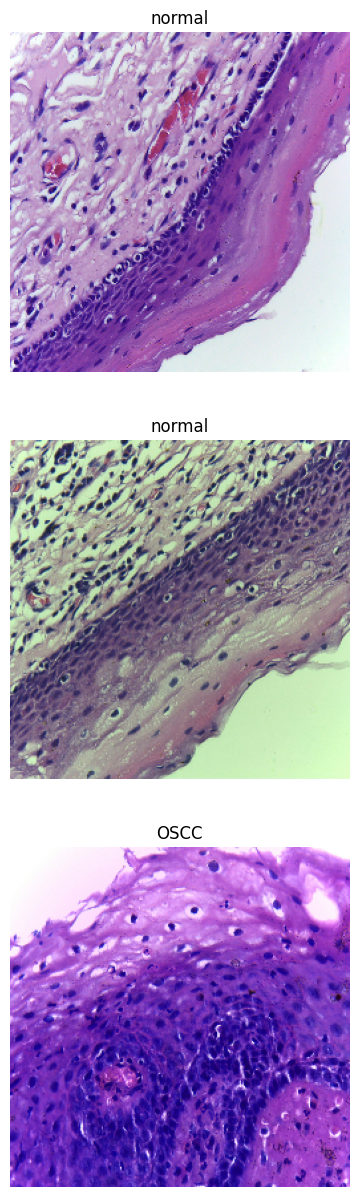

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds


BATCH_SIZE = 70
IMAGE_SIZE = 256
EPOCHS=70
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)

len(dataset)

for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 1, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


train_ds

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

val_ds

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
   # validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

model.evaluate(test_ds)

acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

image_path = "dataset/OSCC/OSCC_100x_101.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

pred = model_3.predict(scaled_img)

output = class_names[np.argmax(pred)]

output

tf.keras.models.save_model(model,"oralcancer")

model_3=tf.keras.models.load_model('oralcancer')



In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [18]:

BATCH_SIZE = 70
IMAGE_SIZE = 256
EPOCHS=70
CHANNELS=3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)

len(dataset)

Found 129 files belonging to 2 classes.
['OSCC', 'normal']


2

(70, 256, 256, 3)
tf.Tensor(
[[[254.   254.   253.  ]
  [254.5  254.5  253.5 ]
  [253.5  253.5  253.5 ]
  ...
  [253.5  253.5  253.5 ]
  [253.   253.   253.  ]
  [254.   254.   253.  ]]

 [[255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  ...
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]]

 [[255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  ...
  [255.   255.   255.  ]
  [255.   255.   255.  ]
  [255.   255.   255.  ]]

 ...

 [[121.25 122.5  208.75]
  [161.25 162.5  229.75]
  [167.75 146.5  224.5 ]
  ...
  [185.   144.75 243.75]
  [121.75 104.75 217.  ]
  [253.75 251.25 252.75]]

 [[145.   121.5  210.  ]
  [149.25 159.25 244.  ]
  [152.25 129.25 219.75]
  ...
  [181.25 156.75 233.25]
  [252.75 251.5  251.75]
  [253.75 254.25 253.5 ]]

 [[166.75 146.   231.75]
  [164.75 138.75 224.5 ]
  [176.75 160.5  238.25]
  ...
  [252.25 253.   250.  ]
  [174.75 195.   245.25]
  [106.25  93.   205.5 ]]], shape=(256, 256,

ValueError: num must be an integer with 1 <= num <= 3, not 4

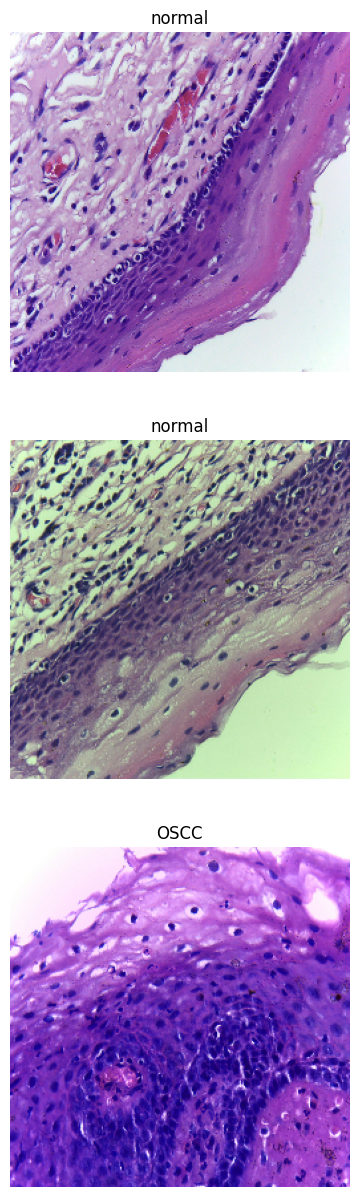

In [19]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 1, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (70, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (70, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (70, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (70, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (70, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (70, 60, 60, 64)         

In [24]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
   # validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

model.evaluate(test_ds)

acc = history.history['accuracy']
loss = history.history['loss']


Epoch 1/70
1/1 [==============================] - 14s 14s/step - loss: 1.9906 - accuracy: 0.7288
Epoch 2/70
1/1 [==============================] - 9s 9s/step - loss: 1.6546 - accuracy: 0.7288
Epoch 3/70
1/1 [==============================] - 4s 4s/step - loss: 1.0964 - accuracy: 0.7288
Epoch 4/70
1/1 [==============================] - 7s 7s/step - loss: 0.7555 - accuracy: 0.7288
Epoch 5/70
1/1 [==============================] - 5s 5s/step - loss: 0.8208 - accuracy: 0.7288
Epoch 6/70
1/1 [==============================] - 9s 9s/step - loss: 0.6528 - accuracy: 0.7288
Epoch 7/70
1/1 [==============================] - 9s 9s/step - loss: 0.7312 - accuracy: 0.3390
Epoch 8/70
1/1 [==============================] - 8s 8s/step - loss: 0.7126 - accuracy: 0.4407
Epoch 9/70
1/1 [==============================] - 5s 5s/step - loss: 0.6118 - accuracy: 0.7288
Epoch 10/70
1/1 [==============================] - 4s 4s/step - loss: 0.6973 - accuracy: 0.7288
Epoch 11/70
1/1 [==============================

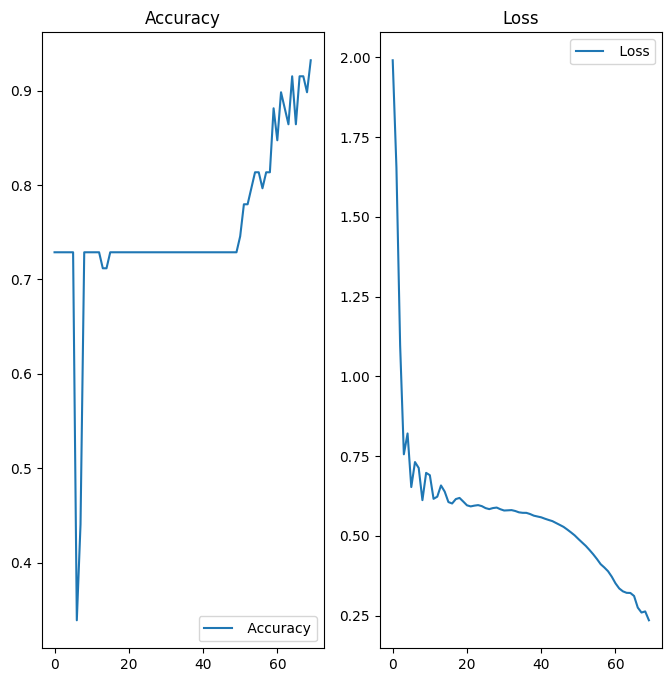

1/1 [==============================] - 0s 388ms/step


'OSCC'

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

image_path = "dataset/OSCC/OSCC_100x_101.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

pred = model_3.predict(scaled_img)

output = class_names[np.argmax(pred)]

output



In [33]:
tf.keras.models.save_model(model,"oralcancer")

INFO:tensorflow:Assets written to: oralcancer\assets


INFO:tensorflow:Assets written to: oralcancer\assets


In [34]:
model_3=tf.keras.models.load_model('oralcancer')